In [289]:
# https://data-analysis-stats.jp/%E6%B7%B1%E5%B1%9E%E5%AD%A6%E7%BF%92/keras-autoencoder-%E3%81%A7%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%80%8C%E8%A9%90%E6%AC%BA%E6%A4%9C%E7%9F%A5%E3%80%8D/
# https://qiita.com/tk-tatsuro/items/10e9dbb3f2cf030e2119
!pip install lightGBM


In [290]:
from pathlib import Path
import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# CSVファイルを読み込む
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
print("train_data;",len(train))
print("test_data;",len(test))

train_data; 3489
test_data; 3489


In [291]:
# trainデータとtestデータをミックスしている。
# 特長量エンジニアリングを別々にやるのは面倒なので、ここで合体させて、学習時に分けるようにしていると思われる。賢い。
def merge_train_test(df_train, df_test):
    if "ProdTaken" not in df_test.columns.tolist():
        df_test["ProdTaken"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

# 合体させたときにgenre=-100にしているので、それを起点にtrainデータとtestデータを分ける。
def split_train_test(df):
    df_train = df[df["ProdTaken"] != -100]
    df_test = df[df["ProdTaken"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

In [292]:
# 特長量生成

# merge_data['Count'] = 1 # 利用回数の列を追加し、値を1とする
# daily_usage_per_customer = merge_data.groupby(['Date', 'CUSTOMER_ID'])['Count'].sum() # 顧客IDごとに日付ごとの利用回数を合計して、1日の利用回数を計算

# #上記mergeとdaily_usage_per_customerを結合
# left_DataFrame = merge_data
# right_DataFrame = daily_usage_per_customer
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on=["CUSTOMER_ID","Date"], suffixes=('_x', '_total'))

# merge_data['daily_usage-mean_nb_tx_per_day'] = merge_data.apply(lambda row: row['Count_total'] - row['mean_nb_tx_per_day'], axis=1) #１日の利用回数－平均の利用回数
# merge_data = merge_data.drop(['Count_x','Count_total'], axis=1) #'count' 列を削除
# # print(merge_data)

In [293]:
# #距離計算
# #関数√(x_cus-x_ter)^2
# import numpy as np
# def func(row):
#     return np.sqrt((row['x_customer_id'] - row['x_terminal_id'])**2) + np.sqrt((row['y_customer_id'] - row['y_terminal_id'])**2)

# #上記関数関数当てはめ
# merge_data['distance'] = merge_data.apply(func, axis=1)
# # print(merge_data)

In [294]:
# merge_data['TX_AMOUNT-mean'] = merge_data.apply(lambda row: row['TX_AMOUNT'] - row['mean_amount'], axis=1)
# merge_data.describe()

In [295]:
# #端末ごとと異常率
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='count')
# pivot_table_total =pivot_table.reset_index()
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='sum')
# pivot_table_fraud =pivot_table.reset_index()
# pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="TERMINAL_ID", right_on="TERMINAL_ID",suffixes=('_total', '_fraud'))
# pivot_table2['per_terminal'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
# pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' 列を削除
# left_DataFrame = merge_data
# right_DataFrame = pivot_table2
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='TERMINAL_ID', suffixes=('_x', '_y'))
# # print(merge_data)
# print(merge_data.columns.tolist())

In [296]:
# #顧客ごとの異常率
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='count')
# pivot_table_total =pivot_table.reset_index()
# # ピボットテーブルを作成し、計算
# pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='sum')
# pivot_table_fraud =pivot_table.reset_index()
# pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="CUSTOMER_ID", right_on="CUSTOMER_ID",suffixes=('_total', '_fraud'))
# pivot_table2['per_customer'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
# pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' 列を削除
# left_DataFrame = merge_data
# right_DataFrame = pivot_table2
# merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='CUSTOMER_ID', suffixes=('_x', '_y'))
# # print(merge_data)
# print(merge_data.columns.tolist())

In [297]:
train.info()
# print(merge_data.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3489 entries, 0 to 3488
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3489 non-null   int64  
 1   Age                     3389 non-null   object 
 2   TypeofContact           3483 non-null   object 
 3   CityTier                3489 non-null   int64  
 4   DurationOfPitch         3368 non-null   object 
 5   Occupation              3489 non-null   object 
 6   Gender                  3489 non-null   object 
 7   NumberOfPersonVisiting  3489 non-null   float64
 8   NumberOfFollowups       3456 non-null   float64
 9   ProductPitched          3489 non-null   object 
 10  PreferredPropertyStar   3489 non-null   float64
 11  NumberOfTrips           3467 non-null   object 
 12  Passport                3489 non-null   int64  
 13  PitchSatisfactionScore  3489 non-null   int64  
 14  Designation             3489 non-null   

In [298]:
# 0   id                      3489 non-null   int64  
#  1   Age                     3389 non-null   object 
# 年齢。欠損している。いい感じに補完したり、欠損値を新たな特長量としたい。
#  2   TypeofContact           3483 non-null   object 
# 顧客への連絡・接触方法　種類と、意味を理解して新たな特長量にできるか？
#  3   CityTier                3489 non-null   int64  
# 顧客の住んでいる都市のランク。1が最高ランク。欠損値なし。
#  4   DurationOfPitch         3368 non-null   object 
# 顧客へのプレゼンテーションの時間。欠損値あり。長さと満足度、成約率の関係性を見たい。
#  5   Occupation              3489 non-null   object 
# 顧客の職業。欠損値なし。職業と成約率の関係性を見たい。あと、どんな種類があるのか。
#  6   Gender                  3489 non-null   object 
# 顧客の性別
#  7   NumberOfPersonVisiting  3489 non-null   float64
# 予定している旅行の同行者の数
#  8   NumberOfFollowups       3456 non-null   float64
# 顧客へのフォローアップの回数。満足度や成約率との相関を見たい。
#  9   ProductPitched          3489 non-null   object 
# 顧客に提案された商品。種類と、成約率の関係性を見たい。
#  10  PreferredPropertyStar   3489 non-null   float64
# 顧客が好むホテルの星の数。欠損値なし。
#  11  NumberOfTrips           3467 non-null   object 
# 顧客が過去に旅行した回数。欠損値あり。旅行回数と成約率の関係性を見たい。
#  12  Passport                3489 non-null   int64  
# パスポートを持っているか。欠損値なし。
#  13  PitchSatisfactionScore  3489 non-null   int64  
# プレゼンテーションの満足度。欠損値なし。
#  14  Designation             3489 non-null   object 
# 顧客の役職。欠損値なし。役職と成約率の関係性を見たい。
#  15  MonthlyIncome           3433 non-null   object 
# 顧客の月収。欠損値あり。収入と成約率の関係性を見たい。
#  16  customer_info           3489 non-null   object 
# 顧客情報。欠損値なし。情報の種類と、成約率の関係性を見たい。
#  17  ProdTaken               3489 non-null   int64  
# 成約したかどうか。0が未成約、1が成約。欠損値なし。


In [299]:
df = merge_train_test(train, test)
df.isnull().sum()


id                          0
Age                       193
TypeofContact              18
CityTier                    0
DurationOfPitch           252
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups          57
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              64
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome             105
customer_info               0
ProdTaken                   0
dtype: int64

In [300]:
# それぞれの特徴量のユニークを可視化し、特徴量を前処理する
# df["Age"].unique()
# 入力がバラバラなので、数値に変換する
# すべての年齢に歳がついているので、最後の位置文字を取り除く
df["Age"] = df["Age"].str[:-1]
# 半角数字、nanはそのままとして、全角数字だった場合半角数字に変換する。漢字の数字は変換できないのでそのままとする。
# 全角数字を半角数字に変換する関数
def zenkaku_to_hankaku(s):
    return s.translate(str.maketrans('０１２３４５６７８９', '0123456789'))

# 全角漢数字を半角数字に変換する関数
kanji_to_num = {
    '一': '1', '二': '2', '三': '3', '四': '4', '五': '5',
    '六': '6', '七': '7', '八': '8', '九': '9', '〇': '0',
    '十': '10', '百': '100', '千': '1000'
}

def kanji_to_hankaku(s):
    num = 0
    unit = 1
    temp = 0
    for char in s:
        if char in kanji_to_num:
            digit = kanji_to_num[char]
            # digitは文字列なので、intに変換する
            digit = int(digit)
            if digit >= 10:
                if temp == 0:
                    temp = 1
                num += temp * digit
                temp = 0
            else:
                temp = temp * 10 + digit
        else:
            return s  # 漢数字以外の文字が含まれている場合は変換しない
    num += temp
    return str(num)

# 変換を適用する関数
def convert_age(age):
    if pd.isna(age):
        return age
    age = str(age)
    age = zenkaku_to_hankaku(age)
    age = kanji_to_hankaku(age)
    try:
        return int(age)
    except ValueError:
        return age

# 変換を適用
df['Age'] = df['Age'].apply(convert_age)

df["Age"]


0       50.0
1       56.0
2        NaN
3       37.0
4       48.0
        ... 
6973    41.0
6974    44.0
6975    24.0
6976    25.0
6977    44.0
Name: Age, Length: 6978, dtype: float64

In [301]:
df["customer_info"].unique()

array(['未婚 車未所持 子供なし', '離婚済み,車あり,子供無し', '結婚済み、自動車未所有,子供なし', ...,
       '離婚済み／車保有／子供有り(1人)', '結婚済み\t車未所持\t子供有り 3人',
       '未婚\u3000車なし\u3000子供3人'], dtype=object)

In [302]:
# NumberOfTripsの前処理。
# 変換マッピングを作成
mapping = {
    '年に1回': 1,
    '年に2回': 2,
    '年に3回': 3,
    '年に4回': 4,
    '年に5回': 5,
    '年に6回': 6,
    '年に7回': 7,
    '年に8回': 8,
    '半年に1回': 2,  # 半年に1回は年に2回
    '四半期に1回': 4  # 四半期に1回は年に4回
}

# 変換関数を定義
def convert_trips(value):
    if pd.isna(value):
        return np.nan
    if value in mapping:
        return mapping[value]
    try:
        return int(value)
    except ValueError:
        return np.nan
# 変換を適用
df["NumberOfTrips"] = df["NumberOfTrips"].apply(convert_trips)
df["NumberOfTrips"].unique()



array([ 5.,  2.,  4.,  1.,  6.,  3.,  7.,  8., nan])

In [303]:
# DurationOfPitchの前処理。秒に変換する。
df["DurationOfPitch"].unique()
# 秒のものは秒までを取り出す。分のものは秒に変換する。
def convert_duration(duration):
    if pd.isna(duration):
        return duration
    duration = str(duration)
    if "秒" in duration:
        # 秒のものは秒までを取り出す
        return int(duration[:-1])
    if "分" in duration:
        return int(duration[:-1]) * 60
    return duration

df["DurationOfPitch"] = df["DurationOfPitch"].apply(convert_duration)
df["DurationOfPitch"]

0        900.0
1        840.0
2        600.0
3       1080.0
4       1020.0
         ...  
6973     840.0
6974    2100.0
6975    1260.0
6976     540.0
6977     480.0
Name: DurationOfPitch, Length: 6978, dtype: float64

In [304]:
# 年齢の処理。男性が1、女性が0に変換する。
df["Gender"].unique()
# m、M、ｍ、Ｍを男性に、f、F、ｆ、Ｆを女性に変換する。
# 文字列が全角だったら半角に変換する。
def zenkaku_to_hankaku(s):
    return s.translate(str.maketrans('ｍｆＭＦMF', 'mfmfmf'))

def gender_to_int(s):
    num = 0
    unit = 1
    temp = 0
    for char in s:
        if char == "m":
            return 1
        if char == "f":
            return 0
        return s
    return str(num)

# 変換を適用する関数
def convert_gender(gender):
    if pd.isna(gender):
        return gender
    gender = str(gender)
    gender = zenkaku_to_hankaku(gender)
    gender = gender_to_int(gender)
    try:
        return int(gender)
    except ValueError:
        return gender
    
df["Gender"] = df["Gender"].apply(convert_gender)
# 最初の文字がmだったら1、fだったら0に変換する。

df["Gender"].head()


def zenkaku_to_hankaku_pp(s):
    zenkaku = 'ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ０１２３４５６７８９'
    hankaku = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789'
    table = str.maketrans(zenkaku, hankaku)
    
    return s.translate(str.maketrans(table))

def pp_to_int(s):
    if s[0] == "b":
        re= 0
    elif s[0] == "s":
        re= 1
    elif s[0] == "d":
        re = 2
    elif s[0] == "k":
        re = 3
    elif s[0] == "B":
        re = 0
    elif s[0] == "S":
        re = 1
    elif s[0] == "D":
        re = 2
    elif s[0] == "K":
        re = 3
    elif s[0] == "ᗞ":
        re = 2
    elif s[0] == "Ꭰ":
        re = 2
    elif s[0] == "В":
        re = 0
    elif s[0] == "ꓢ":
        re = 1
    elif "Β" in s:
        re = 0
    elif "𐊡" in s:
        re = 0
    elif "Ѕ" in s:
        re = 1
    elif "Տ" in s:
        re = 1
    elif "𝙳" in s:
        re = 2
    else:
        print(s[0])
        re = -100
    return re

def designation_to_int(s):
    if "E" == s[0]:
        re = 0
    elif "S" == s[0]:
        re = 1
    elif "Ѕ" == s[0]:
        re = 1
    elif "Տenior" in s:
        re = 1
    elif "A" == s[0]:
        re = 2
    elif "А" in s:
        re = 2
    elif "M" == s[0]:
        re = 3
    elif "Μ" == s[0]:
        re = 3
    elif "V" == s[0]:
        re = 4
    elif "Е" == s[0]:
        re = 0
    elif "ΑVP" in s:
        re = 2    

    else:
        print(s)
        re = -100
    return re

# 変換を適用する関数
def convert_pp(pp):
    if pd.isna(pp):
        return pp
    pp = str(pp)
    pp = zenkaku_to_hankaku_pp(pp)
    pp = pp_to_int(pp)
    try:
        return int(pp)
    except ValueError:
        return pp
df["ProductPitched"] = df["ProductPitched"].apply(convert_pp)
df["ProductPitched"].unique()
# 0がBasic、1がStandard、2がDeluxe、3がKing

def convert_designation(designation):
    if pd.isna(designation):
        return designation
    designation = str(designation)
    designation = zenkaku_to_hankaku_pp(designation)
    designation = designation_to_int(designation)
    try:
        return int(designation)
    except ValueError:
        return designation
    
# Exective:0, Senior Manager:1, AVP:2, Manager:3、VP:4
df["Designation"] = df["Designation"].apply(convert_designation)
df["Designation"].unique()
    

array([0, 1, 2, 3, 4])

In [305]:
# MonthlyIncome
def convert_monthincome(monthincome):
    if pd.isna(monthincome):
        return monthincome
    monthincome = str(monthincome)
    if "月" in monthincome:
        # 月収万円を省略
        monthincome = monthincome[2:-2]
        monthincome = float(monthincome)  * 10000
    try:
        return float(monthincome)
    except ValueError:
        return monthincome
    
# Exective:0, Senior Manager:1, AVP:2, Manager:3、VP:4
df["MonthlyIncome"] = df["MonthlyIncome"].apply(convert_monthincome)
df["MonthlyIncome"].describe()

count      6873.000000
mean     356131.710316
std       76149.009367
min      200000.000000
25%      300000.000000
50%      342075.000000
75%      400000.000000
max      600000.000000
Name: MonthlyIncome, dtype: float64

In [306]:
# customer_info
import re
    
def classification(customer_info):
    print(customer_info)
    if "未婚" in str(customer_info[0]):
        married = 0
    elif "独身" in str(customer_info[0]):
        married = 0
    elif "離婚" in str(customer_info[0]):
        married = 2
    elif "結婚" in str(customer_info[0]):
        married = 1
    else:
        print(customer_info[0])

    if "車未所持" in str(customer_info[1]):
        has_car = 0
    elif "未所有" in str(customer_info[1]):
        has_car = 0
    elif "乗用車なし" in str(customer_info[1]):
        has_car = 0
    elif "車あり" in str(customer_info[1]):
        has_car = 1
    elif "車所持" in str(customer_info[1]):
        has_car = 1
    elif "車保有" in str(customer_info[1]):
        has_car = 1
    elif "自動車所有" in str(customer_info[1]):
        has_car = 1
    else:
        print(customer_info[1])



    if "なし" in str(customer_info[2]):
        has_child = 0
    elif "無し" in str(customer_info[2]):
        has_child = 0
    elif "無子" in str(customer_info[2]):
        has_child = 0
    elif "子供ゼロ" in str(customer_info[2]):
        has_child = 0
        #非育児家庭は別の変数にするのもあり？？
    elif "非育児家庭" in str(customer_info[2]):
        has_child = 0
    else:
        print(customer_info[2])


    return married, has_car, has_child


def split(text):
    # カンマで囲まれている場合は削除する

    if (text.startswith("'") and text.endswith("'")) or (text.startswith('"') and text.endswith('"')):
        text = text[1:-1]
    text = re.sub(r"^['\"]|['\"]$", '', text)
    # 得られた文字列をカンマ、全角カンマ、スペース、全角スペースで分割する
    text = re.split(r',|、| |　|／|/|\t', text)
    print(text)
    return text
    



# 変換を適用する関数
def convert_customer_info(customer_info):
    if pd.isna(customer_info):
        return customer_info
    customer_info = str(customer_info)
    customer_info = split(customer_info)
    married, has_car, has_child = classification(customer_info)
    try:
        return int(married),int(has_car), int(has_child)
    except ValueError:
        return married, has_car, has_child
    
df["customer_info"] = df["customer_info"].apply(convert_customer_info)
# 最初の文字がmだったら1、fだったら0に変換する。

# 未婚0、結婚1、離婚2、車あり1、なし0、子供あり1、なし0
df["customer_info"].head()


['未婚', '車未所持', '子供なし']
['未婚', '車未所持', '子供なし']
['離婚済み', '車あり', '子供無し']
['離婚済み', '車あり', '子供無し']
['結婚済み', '自動車未所有', '子供なし']
['結婚済み', '自動車未所有', '子供なし']
['離婚済み', '車所持', '子供無し']
['離婚済み', '車所持', '子供無し']
['独身', '車所持', '無子']
['独身', '車所持', '無子']
['独身', '車未所持', '子供ゼロ']
['独身', '車未所持', '子供ゼロ']
['独身', '自家用車あり', '子供なし']
['独身', '自家用車あり', '子供なし']
['結婚済み', '車未所持', '子供なし']
['結婚済み', '車未所持', '子供なし']
['独身', '車未所持', '子供無し']
['独身', '車未所持', '子供無し']
['結婚済み', '車所持', '非育児家庭']
['結婚済み', '車所持', '非育児家庭']
['未婚', '車保有', '子供なし']
['未婚', '車保有', '子供なし']
['離婚済み', '車あり', '子供なし']
['離婚済み', '車あり', '子供なし']
['独身', '車所持', '子供なし']
['独身', '車所持', '子供なし']
['結婚済み', '車所持', '非育児家庭']
['結婚済み', '車所持', '非育児家庭']
['独身', '車所持', '無子']
['独身', '車所持', '無子']
['独身', '車所持', '子供なし']
['独身', '車所持', '子供なし']
['独身', '車未所持', '子供なし']
['独身', '車未所持', '子供なし']
['未婚', '車所持', '子供無し']
['未婚', '車所持', '子供無し']
['結婚済み', '自動車未所有', '子供無し']
['結婚済み', '自動車未所有', '子供無し']
['結婚済み', '自動車未所有', '子供なし']
['結婚済み', '自動車未所有', '子供なし']
['未婚', '車保有なし', '子供なし']
['未婚', '車保有なし', '子供なし']
['離婚済み

UnboundLocalError: local variable 'has_car' referenced before assignment

In [ ]:
# TypeofContactのone-hotエンコーディング、ついでにunknownの列名を変更している。
df = pd.concat([df, pd.get_dummies(df["TypeofContact"]).astype(int).rename(columns={np.nan: "TypeofContact_nan"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["Occupation"]).astype(int).rename(columns={np.nan: "Occupation_nan"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["CityTier"]).astype(int).rename(columns={1: "CityTier_1", 2: "CityTier_2", 3: "CityTier_3"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["NumberOfPersonVisiting"]).astype(int).rename(columns={1: "NumberOfPersonVisiting_1", 2: "NumberOfPersonVisiting_2", 3: "NumberOfPersonVisiting_3", 4: "NumberOfPersonVisiting_4"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["ProductPitched"]).astype(int).rename(columns={0: "ProductPitched_0", 1: "ProductPitched_1", 2: "ProductPitched_2", 3: "ProductPitched_3"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["PreferredPropertyStar"]).astype(int).rename(columns={3: "PreferredPropertyStar_3", 4: "PreferredPropertyStar_4", 5: "PreferredPropertyStar_5"})], axis=1)
df = pd.concat([df, pd.get_dummies(df["Passport"]).astype(int)], axis=1)
df = pd.concat([df, pd.get_dummies(df["Designation"]).astype(int).rename(columns={0: "Designation_0", 1: "Designation_1", 2: "Designation_2", 3: "Designation_3", 4: "Designation_4"})], axis=1)

# TypeofContactは2値しかないのでカウントエンコーディングには向かない。

class CountEncoder:
    def fit(self, series):
        # "series"ごとの出現回数をカウント
        self.counts = series.groupby(series).count()
        return self

    def transform(self, series):
        # "series"の各要素を、fit時に集計した出現回数に置換
        return series.map(self.counts).fillna(0)

    def fit_transform(self, series):
        # fitとtransformをまとめて実行
        return self.fit(series).transform(series)
columns_count_enc = ["CityTier","NumberOfPersonVisiting","NumberOfFollowups","ProductPitched","NumberOfTrips","Passport","PitchSatisfactionScore","Designation"]
for col in columns_count_enc:
    # regionの出現回数をカウントして、新しい列を作成している。
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    # 欠損値をnanに変換している。locはnanの行を取得している。
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan


columns_label_enc = ["TypeofContact","Occupation","CityTier","NumberOfPersonVisiting"]
for col in columns_label_enc:
    # regionのラベルエンコーディングを行っている。
    # ラベルエンコーディングとは、カテゴリ変数を数値に変換すること。ワンホットエンコーディングと違い、数値が大小関係を持つため、モデルが大小関係を学習できる。どちらかを採用すること。
    df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "labelenc_" + col] = np.nan

df.head()


,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,countenc_NumberOfFollowups,countenc_ProductPitched,countenc_NumberOfTrips,countenc_Passport,countenc_PitchSatisfactionScore,countenc_Designation,labelenc_TypeofContact,labelenc_Occupation,labelenc_CityTier,labelenc_NumberOfPersonVisiting
0,0,50.0,Self Enquiry,2,900.0,Large Business,1,1.0,4.0,0,...,2746.0,2347.0,977.0,690.0,1452.0,2330.0,1.0,0.0,1.0,0.0
1,1,56.0,Company Invited,1,840.0,Salaried,1,1.0,4.0,1,...,2746.0,2254.0,2277.0,690.0,1452.0,1632.0,0.0,1.0,0.0,0.0
2,2,NaN,Self Enquiry,1,600.0,Large Business,0,1.0,3.0,0,...,2536.0,2347.0,333.0,6288.0,1452.0,2330.0,1.0,0.0,0.0,0.0
3,3,37.0,Self Enquiry,2,1080.0,Small Business,0,1.0,3.0,1,...,2536.0,2254.0,801.0,6288.0,243.0,1632.0,1.0,2.0,1.0,0.0
4,4,48.0,Company Invited,3,1020.0,Small Business,0,1.0,3.0,0,...,2536.0,2347.0,333.0,6288.0,1452.0,2330.0,0.0,2.0,2.0,0.0


In [ ]:
df.isnull().sum()


id                                   0
Age                                193
TypeofContact                       18
CityTier                             0
DurationOfPitch                    252
Occupation                           0
Gender                               0
NumberOfPersonVisiting               0
NumberOfFollowups                   57
ProductPitched                       0
PreferredPropertyStar                0
NumberOfTrips                       64
Passport                             0
PitchSatisfactionScore               0
Designation                          0
MonthlyIncome                      105
customer_info                        0
ProdTaken                            0
Company Invited                      0
Self Enquiry                         0
Large Business                       0
Salaried                             0
Small Business                       0
CityTier_1                           0
CityTier_2                           0
CityTier_3               

ProdTaken
1    0.142448
Name: count, dtype: float64


Text(-0.5, 10, 'contract rate  = 0.14244769274863858')

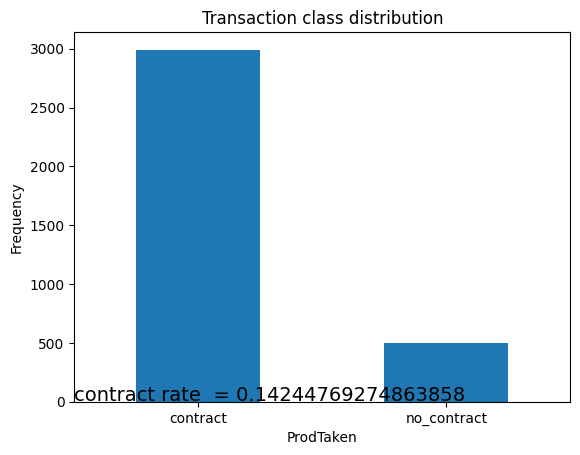

In [ ]:
# 正常データと異常データの頻度を確認
import matplotlib.pyplot as plt
LABELS = ["contract", "no_contract"]

no_contract = train[train.ProdTaken == 0]
no_contract_num = no_contract['ProdTaken'].value_counts()
contract = train[train.ProdTaken == 1]
contract_num = contract['ProdTaken'].value_counts()
# 成約率を算出
rate = contract_num / (no_contract_num[0] + contract_num[1])
print(rate)
count_classes = pd.value_counts(train['ProdTaken'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("ProdTaken")
plt.ylabel("Frequency")
plt.text(-0.5, 10, 'contract rate  = {}'.format(rate[1]), fontsize = 14)

AttributeError: 'DataFrame' object has no attribute 'per_customer'

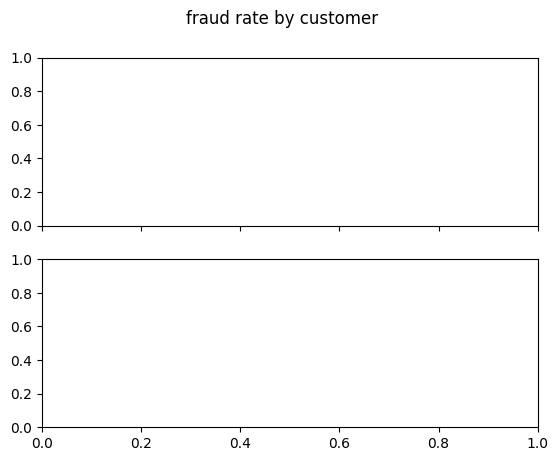

In [ ]:
# 成約、不成約をそれぞれの特長量のヒストグラムで可視化する
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('fraud rate by customer')

bins = 50

ax1.hist(no_contract.per_customer, bins = bins)
ax1.set_title('no_contract')

ax2.hist(contract.per_customer, bins = bins)
ax2.set_title('contract')

plt.xlabel('per_customer ($)')
plt.ylabel('Histgrum')
plt.xlim((0, 0.2))
plt.yscale('log')
plt.show();

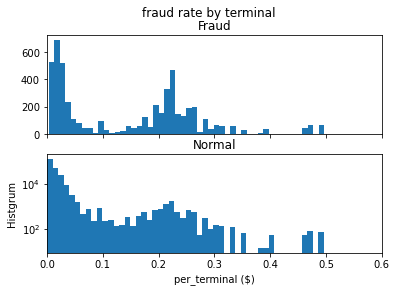

In [ ]:
# 端末ごとの不正利用率を可視化
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('fraud rate by terminal')

bins = 50

ax1.hist(frauds.per_terminal, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.per_terminal, bins = bins)
ax2.set_title('Normal')

plt.xlabel('per_terminal ($)')
plt.ylabel('Histgrum')
plt.xlim((0, 0.6))
plt.yscale('log')
plt.show();

In [ ]:
frauds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5237 entries, 8 to 233730
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CUSTOMER_ID                     5237 non-null   int64  
 1   TERMINAL_ID                     5237 non-null   int64  
 2   TX_AMOUNT                       5237 non-null   float64
 3   TX_FRAUD                        5237 non-null   int64  
 4   x_customer_id                   5237 non-null   float64
 5   y_customer_id                   5237 non-null   float64
 6   mean_amount                     5237 non-null   float64
 7   std_amount                      5237 non-null   float64
 8   mean_nb_tx_per_day              5237 non-null   float64
 9   x_terminal_id                   5237 non-null   float64
 10  y_terminal_id                   5237 non-null   float64
 11  Hour                            5237 non-null   int64  
 12  Week_Weekend                    

In [ ]:
normal.describe()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,Hour,Week_Weekend,daily_usage-mean_nb_tx_per_day,distance,TX_AMOUNT-mean,per_terminal,per_customer
count,228504.000000,228504.000000,228504.000000,228504.0,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000,228504.000000
mean,496.064607,992.925809,53.134099,0.0,50.165919,50.452665,51.728546,25.864273,2.649689,50.198368,50.415622,11.502044,0.285269,0.945308,4.206278,1.405554,0.019522,0.021872
std,285.280871,575.913831,39.361693,0.0,28.714973,28.404311,27.440338,13.720169,0.962384,28.666655,28.364458,5.057295,0.451543,1.701983,1.580538,27.560970,0.046488,0.022486
min,0.000000,0.000000,0.000000,0.0,0.007245,0.036734,5.063101,2.531550,0.018782,0.011437,0.009695,0.000000,0.000000,-2.999725,0.014590,-99.348075,0.000000,0.000000
25%,249.000000,493.000000,21.150000,0.0,25.805921,27.459470,28.606102,14.303051,1.956902,25.979169,27.771273,8.000000,0.000000,-0.165446,3.076227,-12.544063,0.000000,0.000000
50%,498.000000,998.000000,44.810000,0.0,48.968491,49.236141,51.641807,25.820903,2.836935,49.248065,49.074012,11.000000,0.000000,0.778108,4.378299,0.427901,0.007576,0.015831
75%,741.000000,1483.000000,76.850000,0.0,74.735746,75.945025,75.288972,37.644486,3.433593,75.012425,75.546305,15.000000,1.000000,1.873108,5.453310,14.517521,0.017241,0.035176
max,999.000000,1999.000000,219.950000,0.0,99.994897,99.996402,99.981815,49.990907,3.999725,99.859909,99.987579,23.000000,1.000000,24.006580,7.066337,142.442375,0.496403,0.125737


In [ ]:
# 特徴量を合わせるために顧客ごとの不正利用率は削除
# train_total = train_total.drop(['per_customer'], axis=1) #'count' 列を削除
# print(merge_data)
print(train_total.columns.tolist())
train_total.info()

['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_FRAUD', 'x_customer_id', 'y_customer_id', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'x_terminal_id', 'y_terminal_id', 'Hour', 'Week_Weekend', 'daily_usage-mean_nb_tx_per_day', 'distance', 'TX_AMOUNT-mean', 'per_terminal', 'per_customer']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 233741 entries, 0 to 233740
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   CUSTOMER_ID                     233741 non-null  int64  
 1   TERMINAL_ID                     233741 non-null  int64  
 2   TX_AMOUNT                       233741 non-null  float64
 3   TX_FRAUD                        233741 non-null  int64  
 4   x_customer_id                   233741 non-null  float64
 5   y_customer_id                   233741 non-null  float64
 6   mean_amount                     233741 non-null  float64
 7   std_amount                     

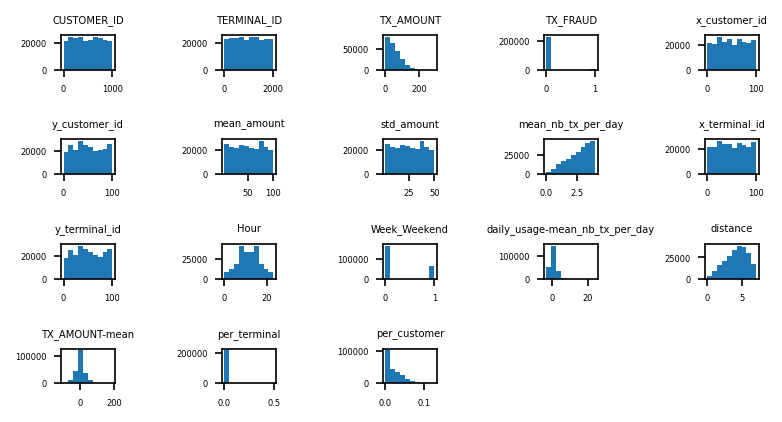

In [ ]:
fig = plt.figure(dpi=150)
for i, col in enumerate(train_total.columns):
    plt.rcParams["font.size"] = 4
    plt.subplots_adjust(wspace=2, hspace=2)
    # plt.figure(figsize=(4, 4))
    plt.subplot2grid((5, 5), (i//5 ,i%5))
    plt.hist(train_total[col])
    plt.title(col)


In [ ]:
train_total.describe()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,Hour,Week_Weekend,daily_usage-mean_nb_tx_per_day,distance,TX_AMOUNT-mean,per_terminal,per_customer
count,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000
mean,496.002113,993.242910,53.238592,0.022405,50.218664,50.426106,51.750050,25.875025,2.650788,50.250575,50.388195,11.502787,0.285115,1.051844,4.205005,1.488542,0.022405,0.022405
std,285.385968,575.396291,39.598041,0.147997,28.732255,28.411580,27.458667,13.729334,0.962405,28.682935,28.371211,5.059637,0.451470,2.072314,1.580324,27.752827,0.053095,0.022821
min,0.000000,0.000000,0.000000,0.000000,0.007245,0.036734,5.063101,2.531550,0.018782,0.011437,0.009695,0.000000,0.000000,-2.999725,0.014590,-99.348075,0.000000,0.000000
25%,249.000000,494.000000,21.150000,0.000000,25.868407,27.459470,28.606102,14.303051,1.956902,25.983398,27.722008,8.000000,0.000000,-0.152141,3.076227,-12.531736,0.000000,0.000000
50%,497.000000,999.000000,44.830000,0.000000,48.968491,49.236141,51.641807,25.820903,2.836935,49.272971,49.074012,11.000000,0.000000,0.791726,4.376251,0.449185,0.008130,0.016026
75%,741.000000,1482.000000,76.920000,0.000000,74.735746,75.945025,75.288972,37.644486,3.438147,75.017241,75.563328,15.000000,1.000000,1.909583,5.449686,14.562206,0.018018,0.036145
max,999.000000,1999.000000,289.200000,1.000000,99.994897,99.996402,99.981815,49.990907,3.999725,99.859909,99.987579,23.000000,1.000000,24.006580,7.066337,189.596150,0.496403,0.125737


In [ ]:
# スコア低下したので除外
# # 最小値を0ではなく一番小さい値にする
# tx_amount_min = train_total[train_total.TX_AMOUNT > 0].TX_AMOUNT.min()
# per_terminal_min = train_total[train_total.per_terminal > 0].per_terminal.min()
# per_customer_min = train_total[train_total.per_customer > 0].per_customer.min()
# print(tx_amount_min)
# train_total["TX_AMOUNT"] += tx_amount_min
# train_total["per_terminal"] += per_terminal_min
# train_total["per_customer"] += per_customer_min
# train_total.describe()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,Hour,Week_Weekend,daily_usage-mean_nb_tx_per_day,distance,TX_AMOUNT-mean,per_terminal,per_customer
count,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000
mean,496.002113,993.242910,53.238592,0.022405,3.613062,3.649253,3.739237,3.046089,0.874013,3.622186,3.649139,11.502787,0.285115,1.051844,4.205005,1.488542,0.022405,0.022405
std,285.385968,575.396291,39.598041,0.147997,1.023597,0.920676,0.728365,0.728365,0.517483,0.977965,0.920163,5.059637,0.451470,2.072314,1.580324,27.752827,0.053095,0.022821
min,0.000000,0.000000,0.000000,0.000000,-4.927449,-3.304042,1.621979,0.928832,-3.974861,-4.470859,-4.636138,0.000000,0.000000,-2.999725,0.014590,-99.348075,0.000000,0.000000
25%,249.000000,494.000000,21.150000,0.000000,3.253022,3.312711,3.353620,2.660473,0.671363,3.257458,3.322227,8.000000,0.000000,-0.152141,3.076227,-12.531736,0.000000,0.000000
50%,497.000000,999.000000,44.830000,0.000000,3.891177,3.896628,3.944332,3.251184,1.042724,3.897376,3.893330,11.000000,0.000000,0.791726,4.376251,0.449185,0.008130,0.016026
75%,741.000000,1482.000000,76.920000,0.000000,4.313959,4.330010,4.321334,3.628186,1.234933,4.317718,4.324971,15.000000,1.000000,1.909583,5.449686,14.562206,0.018018,0.036145
max,999.000000,1999.000000,289.200000,1.000000,4.605119,4.605134,4.604988,3.911841,1.386226,4.603768,4.605046,23.000000,1.000000,24.006580,7.066337,189.596150,0.496403,0.125737


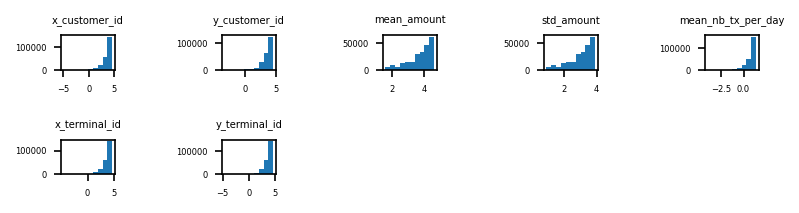

In [ ]:
# 対数変換
log_list = ["x_customer_id","y_customer_id","mean_amount","std_amount","mean_nb_tx_per_day","x_terminal_id","y_terminal_id"]
fig = plt.figure(dpi=150)
for i,indent in enumerate(log_list):
    plt.rcParams["font.size"] = 4
    plt.subplots_adjust(wspace=2, hspace=2)
    train_total[indent] = np.log(train_total[indent])
    plt.subplot2grid((5, 5), (i//5 ,i%5))
    plt.hist(train_total[indent])
    plt.title(indent)
train_total.describe()

In [ ]:
### test dataも同様に前処理を実施

In [ ]:
### test dataも同様に前処理を実施

In [ ]:
### test dataも同様に前処理を実施

In [ ]:
### test dataも同様に前処理を実施

In [ ]:
#trainとcustomerを結合
left_DataFrame = test_data
right_DataFrame = customer_data
merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',left_on="CUSTOMER_ID", right_on="CUSTOMER_ID",suffixes=('_x', '_y'))
#上記mergeとterminal
left_DataFrame = merge_data
right_DataFrame = terminal_data
merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',left_on="TERMINAL_ID", right_on="TERMINAL_ID",suffixes=('_x', '_y'))

#要らない列を削除する
merge_data = merge_data.drop(['TRANSACTION_ID','available_terminals','nb_terminals',], axis=1) #'count' 列を削除

#日付編集
merge_data['TX_DATETIME'] = pd.to_datetime(merge_data['TX_DATETIME'])
merge_data['Date'] = pd.to_datetime(merge_data['TX_DATETIME']).dt.date
merge_data['Hour'] = merge_data['TX_DATETIME'].dt.hour
merge_data['Day_of_Week'] = merge_data['TX_DATETIME'].dt.day_name()
#曜日エンコード
day_mapping = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 'Friday': 0, 'Saturday': 1, 'Sunday': 1}
merge_data['Week_Weekend'] = merge_data['Day_of_Week'].map(day_mapping)
merge_data = merge_data.drop(['TX_DATETIME','Day_of_Week'], axis=1) #'Day_of_Week' 列を削除

columns_list = merge_data.columns.tolist()
print(columns_list)

['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_FRAUD', 'x_customer_id', 'y_customer_id', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'x_terminal_id', 'y_terminal_id', 'Date', 'Hour', 'Week_Weekend']


In [ ]:
merge_data['Count'] = 1 # 利用回数の列を追加し、値を1とする
daily_usage_per_customer = merge_data.groupby(['Date', 'CUSTOMER_ID'])['Count'].sum() # 顧客IDごとに日付ごとの利用回数を合計して、1日の利用回数を計算

#上記mergeとdaily_usage_per_customerを結合
left_DataFrame = merge_data
right_DataFrame = daily_usage_per_customer
merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on=["CUSTOMER_ID","Date"], suffixes=('_x', '_total'))

merge_data['daily_usage-mean_nb_tx_per_day'] = merge_data.apply(lambda row: row['Count_total'] - row['mean_nb_tx_per_day'], axis=1) #１日の利用回数－平均の利用回数
merge_data = merge_data.drop(['Count_x','Count_total'], axis=1) #'count' 列を削除
# print(merge_data)

In [ ]:
#距離計算
#関数√(x_cus-x_ter)^2
import numpy as np
def func(row):
    return np.sqrt((row['x_customer_id'] - row['x_terminal_id'])**2) + np.sqrt((row['y_customer_id'] - row['y_terminal_id'])**2)

#上記関数関数当てはめ
merge_data['distance'] = merge_data.apply(func, axis=1)
# print(merge_data)

In [ ]:
merge_data['TX_AMOUNT-mean'] = merge_data.apply(lambda row: row['TX_AMOUNT'] - row['mean_amount'], axis=1)
# print(merge_data)

In [ ]:
#端末ごとと異常率
# ピボットテーブルを作成し、計算
pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='count')
pivot_table_total =pivot_table.reset_index()
# ピボットテーブルを作成し、計算
pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='TERMINAL_ID',aggfunc='sum')
pivot_table_fraud =pivot_table.reset_index()
pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="TERMINAL_ID", right_on="TERMINAL_ID",suffixes=('_total', '_fraud'))
pivot_table2['per_terminal'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' 列を削除
left_DataFrame = merge_data
right_DataFrame = pivot_table2
merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='TERMINAL_ID', suffixes=('_x', '_y'))
# print(merge_data)
print(merge_data.columns.tolist())

['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_FRAUD', 'x_customer_id', 'y_customer_id', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'x_terminal_id', 'y_terminal_id', 'Date', 'Hour', 'Week_Weekend', 'daily_usage-mean_nb_tx_per_day', 'distance', 'TX_AMOUNT-mean', 'per_terminal']


In [ ]:
#顧客ごとの異常率
# ピボットテーブルを作成し、計算
pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='count')
pivot_table_total =pivot_table.reset_index()
# ピボットテーブルを作成し、計算
pivot_table = pd.pivot_table(merge_data, values='TX_FRAUD', index='CUSTOMER_ID',aggfunc='sum')
pivot_table_fraud =pivot_table.reset_index()
pivot_table2 = pd.merge(pivot_table_total, pivot_table_fraud, how='left',left_on="CUSTOMER_ID", right_on="CUSTOMER_ID",suffixes=('_total', '_fraud'))
pivot_table2['per_customer'] = pivot_table2.apply(lambda row: row['TX_FRAUD_fraud'] / row['TX_FRAUD_total'], axis=1)
pivot_table2 = pivot_table2.drop(['TX_FRAUD_total', 'TX_FRAUD_fraud'], axis=1) #'count' 列を削除
left_DataFrame = merge_data
right_DataFrame = pivot_table2
merge_data = pd.merge(left_DataFrame, right_DataFrame, how='left',on='CUSTOMER_ID', suffixes=('_x', '_y'))
# print(merge_data)
print(merge_data.columns.tolist())

['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_FRAUD', 'x_customer_id', 'y_customer_id', 'mean_amount', 'std_amount', 'mean_nb_tx_per_day', 'x_terminal_id', 'y_terminal_id', 'Date', 'Hour', 'Week_Weekend', 'daily_usage-mean_nb_tx_per_day', 'distance', 'TX_AMOUNT-mean', 'per_terminal', 'per_customer']


In [ ]:
test_total = merge_data.drop(['Date'], axis=1) #'count' 列を削除
test_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57490 entries, 0 to 57489
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CUSTOMER_ID                     57490 non-null  int64  
 1   TERMINAL_ID                     57490 non-null  int64  
 2   TX_AMOUNT                       57490 non-null  float64
 3   TX_FRAUD                        57490 non-null  int64  
 4   x_customer_id                   57490 non-null  float64
 5   y_customer_id                   57490 non-null  float64
 6   mean_amount                     57490 non-null  float64
 7   std_amount                      57490 non-null  float64
 8   mean_nb_tx_per_day              57490 non-null  float64
 9   x_terminal_id                   57490 non-null  float64
 10  y_terminal_id                   57490 non-null  float64
 11  Hour                            57490 non-null  int64  
 12  Week_Weekend                    

1    0.023395
Name: TX_FRAUD, dtype: float64


Text(0.05, 0.92, 'fraud rate  = 0.023395373108366674')

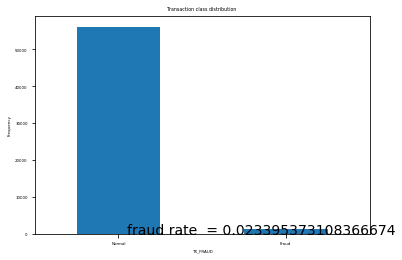

In [ ]:
# 正常データと異常データの頻度を確認
import matplotlib.pyplot as plt
LABELS = ["Normal", "Fraud"]

frauds = test_total[test_total.TX_FRAUD == 1]
frauds_num = frauds['TX_FRAUD'].value_counts()
normal = test_total[test_total.TX_FRAUD == 0]
normal_num = normal['TX_FRAUD'].value_counts()
rate = frauds_num / (frauds_num[1] + normal_num[0])
print(rate)
count_classes = pd.value_counts(test_total['TX_FRAUD'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.rcParams["font.size"] = 14
plt.xticks(range(2), LABELS)
plt.xlabel("TX_FRAUD")
plt.ylabel("Frequency")
plt.text(0.05, 0.92, 'fraud rate  = {}'.format(rate[1]), fontsize = 14)

In [ ]:
# # 最小値を0ではなく一番小さい値にする
# tx_amount_min = test_total[test_total.TX_AMOUNT > 0].TX_AMOUNT.min()
# per_terminal_min = test_total[test_total.per_terminal > 0].per_terminal.min()
# per_customer_min = test_total[test_total.per_customer > 0].per_customer.min()
# print(tx_amount_min)
# test_total["TX_AMOUNT"] += tx_amount_min
# test_total["per_terminal"] += per_terminal_min
# test_total["per_customer"] += per_customer_min
# test_total.describe()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,Hour,Week_Weekend,daily_usage-mean_nb_tx_per_day,distance,TX_AMOUNT-mean,per_terminal,per_customer
count,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000,57490.000000
mean,497.289268,995.652270,52.953300,0.023395,3.606626,3.647941,3.732121,3.038974,0.875538,3.615986,3.649624,11.527709,0.266394,1.061884,4.204223,1.404140,0.023395,0.023395
std,284.823358,574.744774,39.472217,0.151157,1.031006,0.926465,0.734234,0.734234,0.512713,0.984291,0.920809,5.060603,0.442077,2.073322,1.586034,27.595819,0.097439,0.044148
min,0.000000,0.000000,0.000000,0.000000,-4.927449,-3.304042,1.621979,0.928832,-3.817655,-4.470859,-4.636138,0.000000,0.000000,-2.999725,0.014590,-98.249581,0.000000,0.000000
25%,253.000000,502.000000,21.060000,0.000000,3.253022,3.303365,3.350200,2.657053,0.671363,3.257458,3.319643,8.000000,0.000000,-0.168748,3.068474,-12.485918,0.000000,0.000000
50%,499.000000,1002.000000,44.490000,0.000000,3.890794,3.895675,3.943326,3.250179,1.042724,3.894993,3.893876,12.000000,0.000000,0.779245,4.372075,0.387647,0.000000,0.000000
75%,741.000000,1488.000000,76.467500,0.000000,4.311824,4.330010,4.321334,3.628186,1.234933,4.313909,4.324915,15.000000,1.000000,1.939720,5.455561,14.351291,0.000000,0.030612
max,999.000000,1999.000000,291.150000,1.000000,4.605119,4.605134,4.604988,3.911841,1.386226,4.603768,4.605046,23.000000,1.000000,20.191561,7.066337,192.994887,0.956522,0.333333


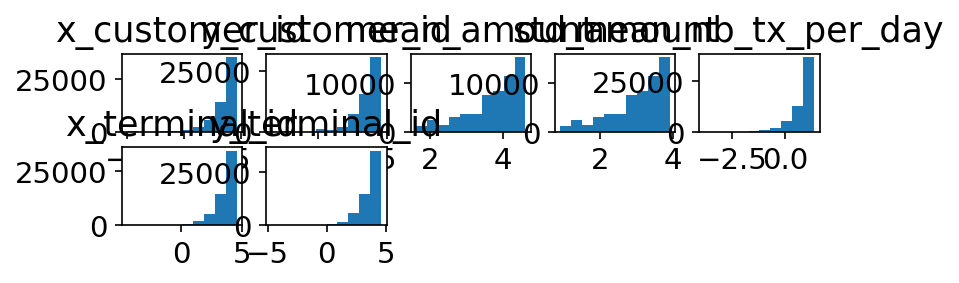

In [ ]:
fig = plt.figure(dpi=150)
for i,indent in enumerate(log_list):
    test_total[indent] = np.log(test_total[indent])
    plt.subplot2grid((5, 5), (i//5 ,i%5))
    plt.hist(test_total[indent])
    plt.title(indent)
test_total.describe()

In [ ]:
# 負荷が重いのか走らないのでコメントアウト
# #特徴量ごとの相関を確認
# from pandas.plotting import scatter_matrix
# train_total.loc[train_total["TX_FRAUD"]==0,"color"]= "red"
# train_total.loc[train_total["TX_FRAUD"]==1,"color"]= "blue"

# color = train_total["color"]
# del train_total["color"]

# input_features = ["TX_FRAUD","x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance"]
# plot = scatter_matrix(
#     train_total[input_features],
#     diagonal = "density",
#     color = color,
#     figsize = (20,20))
train_total.describe()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,Hour,Week_Weekend,daily_usage-mean_nb_tx_per_day,distance,TX_AMOUNT-mean,per_terminal,per_customer
count,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000,233741.000000
mean,496.002113,993.242910,53.238592,0.022405,3.613062,3.649253,3.739237,3.046089,0.874013,3.622186,3.649139,11.502787,0.285115,1.051844,4.205005,1.488542,0.022405,0.022405
std,285.385968,575.396291,39.598041,0.147997,1.023597,0.920676,0.728365,0.728365,0.517483,0.977965,0.920163,5.059637,0.451470,2.072314,1.580324,27.752827,0.053095,0.022821
min,0.000000,0.000000,0.000000,0.000000,-4.927449,-3.304042,1.621979,0.928832,-3.974861,-4.470859,-4.636138,0.000000,0.000000,-2.999725,0.014590,-99.348075,0.000000,0.000000
25%,249.000000,494.000000,21.150000,0.000000,3.253022,3.312711,3.353620,2.660473,0.671363,3.257458,3.322227,8.000000,0.000000,-0.152141,3.076227,-12.531736,0.000000,0.000000
50%,497.000000,999.000000,44.830000,0.000000,3.891177,3.896628,3.944332,3.251184,1.042724,3.897376,3.893330,11.000000,0.000000,0.791726,4.376251,0.449185,0.008130,0.016026
75%,741.000000,1482.000000,76.920000,0.000000,4.313959,4.330010,4.321334,3.628186,1.234933,4.317718,4.324971,15.000000,1.000000,1.909583,5.449686,14.562206,0.018018,0.036145
max,999.000000,1999.000000,289.200000,1.000000,4.605119,4.605134,4.604988,3.911841,1.386226,4.603768,4.605046,23.000000,1.000000,24.006580,7.066337,189.596150,0.496403,0.125737


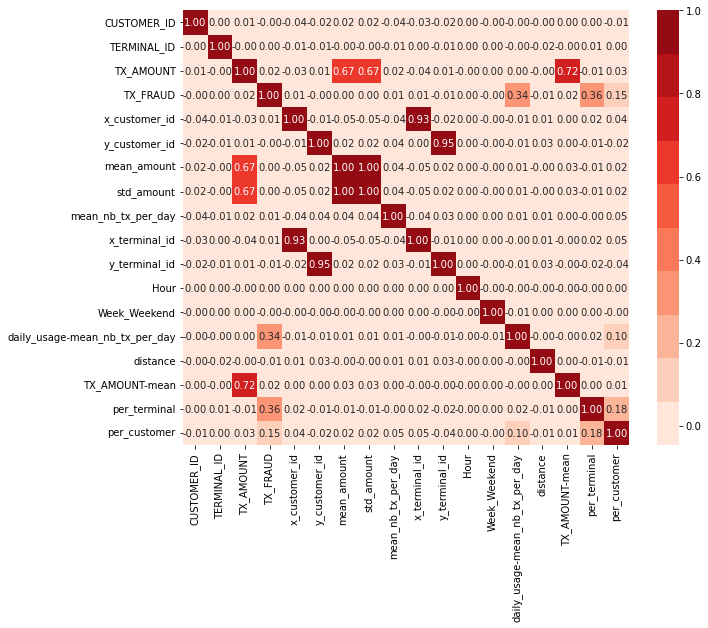

In [ ]:
# 情報量が多く処理が完了しないので8月までのデータでヒートマップ算出する
import seaborn as sns
%matplotlib inline
corrs = np.corrcoef(train_total, rowvar=False)
fig,ax = plt.subplots(figsize=(10,8))

sns.heatmap(corrs, cmap=sns.color_palette('Reds', 10), annot=True,
            fmt='.2f', xticklabels=train_total.columns.tolist(), yticklabels=train_total.columns.tolist())
# input_features = ["x_customer_id","y_customer_id","x_terminal_id","y_terminal_id","distance",'TX_AMOUNT',"TX_AMOUNT-mean","mean_amount","std_amount","mean_nb_tx_per_day"]
# sns.heatmap(train_total[input_features],vmax=1, vmin=-1, center=0)
plt.savefig("heatmap.png")

In [ ]:
##特徴選択

In [ ]:
##特徴選択
!pip install imblearn

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# ②不均衡データへの処置
# 正常データを減らす、異常データを増やす、重みづけ
# まずはtrain dataを再生成
# Trainとtestで同じ顧客、ターミナル情報を持っている（最大、最小がtrainとtestで同じ）ので、
# train dataに顧客、ターミナル情報を紐づけて学習させてみる。
# train_cus = train.merge(customer)
# train_total = train_cus.merge(terminal)
# train_total.info()


# アンダーサンプリング
from imblearn.under_sampling import RandomUnderSampler

target = 'TX_FRAUD'
rs = RandomUnderSampler(random_state=42)
under_sampling ,_ = rs.fit_resample(train_total, train_total[target])

print('*'*20)
print('＜元のデータ＞')
print('0の件数：%d'%len(train_total.query(f'{target}==0')))
print('1の件数：%d'%len(train_total.query(f'{target}==1')))
print('*'*20)
print('＜アンダーサンプリング後のデータ＞')
print('0の件数：%d'%len(under_sampling.query(f'{target}==0')))
print('1の件数：%d'%len(under_sampling.query(f'{target}==1')));

train_total = under_sampling.copy()


********************
＜元のデータ＞
0の件数：228504
1の件数：5237
********************
＜アンダーサンプリング後のデータ＞
0の件数：5237
1の件数：5237


In [ ]:
# 学習データと結果に分割
# 正常データを異常データと同数にして学習
# train_total = under_sampling.copy()
y = train_total['TX_FRAUD']
train_total.drop('TX_FRAUD', axis=1, inplace=True)
# 相関あるのでmean_amountを削除する
train_total.drop('mean_amount', axis=1, inplace=True)
#多重共線性の観点から位置を省いてみる
train_total = train_total.drop(['x_customer_id',"y_customer_id"], axis=1) #'count' 列を削除


y_test_true = test_total['TX_FRAUD']
test_total.drop('TX_FRAUD', axis=1, inplace=True)
test_total.drop('mean_amount', axis=1, inplace=True)
test_total = test_total.drop(['x_customer_id',"y_customer_id"], axis=1) #'count' 列を削除


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def calc_accuracy(y_pred, y_true):
    metric = np.mean(y_true == y_pred)
    return 'accuracy', metric, True

def calc_precision(y_pred, y_true):
    metric = precision_score(y_true, y_pred)
    return 'precison', metric, True

def calc_recall(y_pred, y_true):
    metric = recall_score(y_true, y_pred)
    return 'recall', metric, True

def calc_fscore(fscores):
    metric = np.max(fscores)
    return 'fscore', metric, True

def calc_auc(y_pred, y_true):
    metric = roc_auc_score(y_true, y_pred)
    return 'auc', metric, True

def calc_prauc(y_pred, y_true):
    metric = average_precision_score(y_true, y_pred)
    return 'prauc', metric, True

In [ ]:
def acquire_custom_metircs(preds ,data):
    # precisions, recalls, thresholds = precision_recall_curve(data.get_label(), preds, pos_label=1)
    # thresholds = np.append(thresholds, 1)
    # fscores = 2 * precisions * recalls / (precisions + recalls)
    # threshold_max_fscore = thresholds[np.argmax(fscores)]

    y_true = data.get_label()
    y_pred = np.where(preds > 0.5, 1, 0)

    # return [
    #     calc_accuracy(y_pred, y_true),  ＃ Accuracy
    #     calc_precision(y_pred, y_true),  ＃ Precision
    #     calc_recall(y_pred, y_true),  # Recall
    #     calc_fscore(fscores),  # F1 score
    #     calc_auc(y_pred, y_true),  # ROC AUC
    #     calc_prauc(y_pred, y_true)  # PR AUC
    # ]
    score = calc_precision(y_pred, y_true), # Precision 
    # print("precision")
    # print(score[0])
    return score[0]

In [ ]:
# 上のグリッドサーチで見つけたベストパラメータで全データでの学習、推論を行い結果を算出する。
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     # 'metric': 'rmse',
#     'metric': 'binary_logloss',
#     # 'metric': 'auc', # AUCでもいい
    
#     "seed":31,
#     'random_state': 42,
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     'verbose' : -1,
#     "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
#     "learning_rate": 0.005, #学習率
#     "num_leaves":31,
#     "max_depth":12,
#     "min_data_in_leaf":20,
#     "bagging_fraction":0.8,
#     "bagging_freq":1,
# }
# グリッドサーチは時間かかって終わらないのでそのままにする
# if len(best_params) == 0:
# best_params = params

# 学習データと検証データの分割
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)
train_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10474 entries, 219235 to 233730
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CUSTOMER_ID                     10474 non-null  int64  
 1   TERMINAL_ID                     10474 non-null  int64  
 2   TX_AMOUNT                       10474 non-null  float64
 3   std_amount                      10474 non-null  float64
 4   mean_nb_tx_per_day              10474 non-null  float64
 5   x_terminal_id                   10474 non-null  float64
 6   y_terminal_id                   10474 non-null  float64
 7   Hour                            10474 non-null  int64  
 8   Week_Weekend                    10474 non-null  int64  
 9   daily_usage-mean_nb_tx_per_day  10474 non-null  float64
 10  distance                        10474 non-null  float64
 11  TX_AMOUNT-mean                  10474 non-null  float64
 12  per_terminal              

In [ ]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

In [ ]:
# ## グリッドサーチ
# import lightgbm as lgb

# # https://pythonandai.com/grid-search/
# from sklearn.model_selection import GridSearchCV
# learning_rate = [0.001]
# num_leaves = [31]
# max_depth = [12]
# min_data_in_leaf = [20]
# params = {
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#     # 'metric': 'rmse',
#     'metric': ['binary_logloss',"auc"],
#     # 'metric': 'auc', # AUCでもいい
    
#     # "seed":[31],
#     # 'random_state': [42],
#     # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
#     # 'verbose' : [-1],
#     "num_iterations":[10000], # early stopping で止まるため大きめに設定しておけばよい
    
#     # 以下のパラメータを調整対象とする
#     "learning_rate": learning_rate, #学習率
#     "num_leaves":num_leaves,
#     "max_depth":max_depth,
#     "min_data_in_leaf":min_data_in_leaf,
#     # "bagging_fraction":[0.8],
#     # "bagging_freq":[1],
# }

# lgbm = lgb.LGBMClassifier(random_state=0)
# gcv = GridSearchCV(lgbm, params, cv=3, scoring='precision', return_train_score=True)
# gcv.fit(X_train, y_train)

In [ ]:
# # グリッドサーチの結果から、学習データとテストデータのスコアを取得
# train_score = gcv.cv_results_["mean_train_score"]
# test_score = gcv.cv_results_["mean_test_score"]

# # matplotlib.pyplotを省略名pltとしてインポート 
# import matplotlib.pyplot as plt
# plt.rcParams["font.size"] = 14

# # 学習データのスコアをプロット
# plt.plot(num_leaves, train_score, label="train_score")

# # テストデータのスコアをプロット
# plt.plot(num_leaves, test_score, label="test_score")

# # グラフにタイトルを追加
# plt.title('train_score vs test_score')

# # グラフのx軸に名前を追加
# plt.xlabel('learning_rate')

# # グラフのy軸に名前を追加
# plt.ylabel('precision')

# # 凡例の表示
# plt.legend()

# # グラフの表示
# plt.show()

In [ ]:
# # グリッドサーチの結果から、最適なパラメータを表示
# print("Best parameters: ", gcv.best_params_)

# # 最適なパラメータで学習したモデルを取得
# optimal_model = gcv.best_estimator_

# # 最適なモデルを用いて、評価用データの予測を行う
# predicted_values = optimal_model.predict_proba(test_total)[:,1]


In [ ]:
# from sklearn import metrics
# # 予測結果を用いてAUCを計算
# auc_score = roc_auc_score(y_test_true, predicted_values)

# predicted_values_int = np.where(predicted_values > 0.5, 1, 0)
# precision_score = metrics.precision_score(y_true=y_test_true, y_pred=predicted_values_int)
# recall_score = metrics.recall_score(y_true=y_test_true, y_pred=predicted_values_int)
# print(f'precision_score={precision_score}')
# print(f'recall_score={recall_score}')
# print(f'sum_score={recall_score+precision_score}')


# # 計算したAUCを表示
# print("AUC Score: ", auc_score)
# import seaborn as sns
# from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
#    roc_curve, recall_score, classification_report, f1_score,
#    precision_recall_fscore_support)
# conf_matrix = confusion_matrix(y_test_true, predicted_values_int)
# plt.figure(figsize=(5, 5))
# sns.heatmap(conf_matrix, xticklabels=["Normal","Fraund"], yticklabels=["Normal","Fraund"], annot=True, fmt="d");
# plt.title("Confusion matrix")
# plt.ylabel('True class')
# plt.xlabel('Predicted class')
# plt.show()
# # precision_score = precision_score(y_true=y_test_true, y_pred=predicted_values_int)
# print(f'precision_score={precision_score}')

In [ ]:
# from sklearn import metrics

# precision, recall, thresholds = metrics.precision_recall_curve(y_test_true, predicted_values)

# auc = metrics.auc(recall, precision)
# print(auc)

# plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
# plt.legend()
# plt.title('PR curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.grid(True)
# plt.show()

In [ ]:
# y_pred = predicted_values
# y_pred_label_normal_test = y_pred[y_test_true==0]
# y_pred_label_fraud_test = y_pred[y_test_true==1]
# print(len(y_pred_label_normal_test))
# print(len(y_pred_label_fraud_test))

In [ ]:

# f, (ax) = plt.subplots()
# f.suptitle('Prediction hist Test')


# bins = 50

# ax.hist(y_pred_label_normal_test, bins = bins)
# ax.set_title('normal')

# ax.hist(y_pred_label_fraud_test, bins = bins)
# ax.set_title('fraud')

# plt.xlabel('test pred')
# plt.ylabel('Frequencey')
# plt.xlim((0, 1))
# plt.yscale('log')
# plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
# plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
# plt.show();

In [ ]:
# y_pred_train = optimal_model.predict_proba(train_total)[:,1]
# y_pred_label_normal = y_pred_train[y==0]
# y_pred_label_fraud = y_pred_train[y==1]


In [ ]:

# f, (ax) = plt.subplots()
# f.suptitle('Prediction hist Train')

# bins = 50

# ax.hist(y_pred_label_normal, bins = bins)
# ax.set_title('normal')

# ax.hist(y_pred_label_fraud, bins = bins)
# ax.set_title('fraud')

# plt.xlabel('train pred')
# plt.ylabel('Frequencey')
# plt.xlim((0, 1))
# plt.yscale('log')
# plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
# plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
# plt.show();

In [ ]:
# lghtGBMのグリッドサーチ
## それぞれのハイパラをサーチすることでひとまずパラメータの当たり付けを行う。

# finish

In [ ]:
# 上の方法だとうまく重みづけ学習できないので、別ページを参考に実践する
# https://an-engineer-note.com/?p=312#toc3
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
# dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
# dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[1.0015539  0.99845093 0.99845093 ... 0.99845093 1.0015539  0.99845093]
[1. 1. 1. ... 1. 1. 1.]


In [ ]:
learning_rate = 0.001
num_leaves = 31
max_depth = 12
min_data_in_leaf = 20
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    # 'metric': 'rmse',
    'metric': 'binary_logloss',
    # 'metric': 'auc', # AUCでもいい
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [ ]:

#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 4196, number of negative: 4183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3061
[LightGBM] [Info] Number of data points in the train set: 8379, number of used features: 14
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[6329]	train's binary_logloss: 0.0662658	valid's binary_logloss: 0.102911


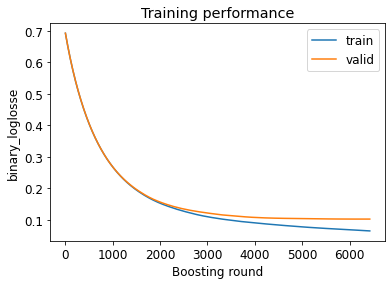

In [ ]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['binary_logloss'], label='train')
plt.plot(evaluation_results['valid']['binary_logloss'], label='valid')
plt.ylabel('binary_loglosse')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [ ]:
y_pred = gbm.predict(test_total)
y_pred_label_normal_test = y_pred[y_test_true==0]
y_pred_label_fraud_test = y_pred[y_test_true==1]
print(len(y_pred_label_normal_test))
print(len(y_pred_label_fraud_test))

56145
1345


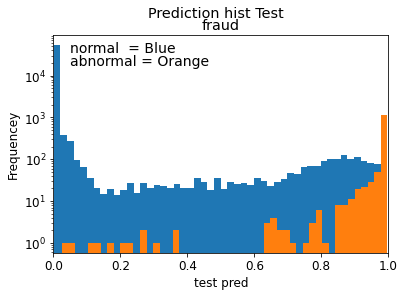

In [ ]:

f, (ax) = plt.subplots()
f.suptitle('Prediction hist Test')


bins = 50

ax.hist(y_pred_label_normal_test, bins = bins)
ax.set_title('normal')

ax.hist(y_pred_label_fraud_test, bins = bins)
ax.set_title('fraud')

plt.xlabel('test pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
plt.show();

In [ ]:
y_pred_train = gbm.predict(train_total)
y_pred_label_normal = y_pred_train[y==0]
y_pred_label_fraud = y_pred_train[y==1]


In [ ]:
train_total.describe()

,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,Hour,Week_Weekend,daily_usage-mean_nb_tx_per_day,distance,TX_AMOUNT-mean,per_terminal,per_customer
count,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000,10474.000000
mean,493.584590,998.938801,55.813026,3.055288,0.890327,3.657753,3.626982,11.473172,0.283464,3.322090,4.184794,3.466763,0.083533,0.033637
std,286.479483,562.666385,44.473935,0.733715,0.501227,0.972735,0.930718,5.088512,0.450701,5.365620,1.564242,31.594332,0.113307,0.026694
min,0.000000,0.000000,0.020000,0.928832,-2.645190,-4.470859,-4.636138,0.000000,0.000000,-2.999725,0.030323,-95.129542,0.000000,0.000000
25%,237.000000,534.000000,21.492500,2.716714,0.690422,3.315993,3.264407,8.000000,0.000000,0.096785,3.102673,-11.918972,0.006944,0.011980
50%,478.000000,1009.000000,45.995000,3.260347,1.054395,3.962262,3.839211,11.000000,0.000000,1.276235,4.339862,1.085666,0.020270,0.031700
75%,742.000000,1472.000000,78.705000,3.657109,1.247242,4.340930,4.330296,15.000000,1.000000,3.522894,5.409174,15.473435,0.192000,0.048309
max,999.000000,1999.000000,289.200000,3.911841,1.386226,4.603768,4.605046,23.000000,1.000000,24.006580,7.066183,189.596150,0.496403,0.125737


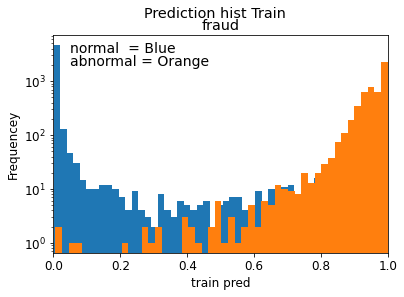

In [ ]:

f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_label_normal, bins = bins)
ax.set_title('normal')

ax.hist(y_pred_label_fraud, bins = bins)
ax.set_title('fraud')

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.92, 'normal  = Blue',transform = ax.transAxes, fontsize = 14)
plt.text(0.05, 0.86, 'abnormal = Orange',transform = ax.transAxes, fontsize = 14)
plt.show();

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

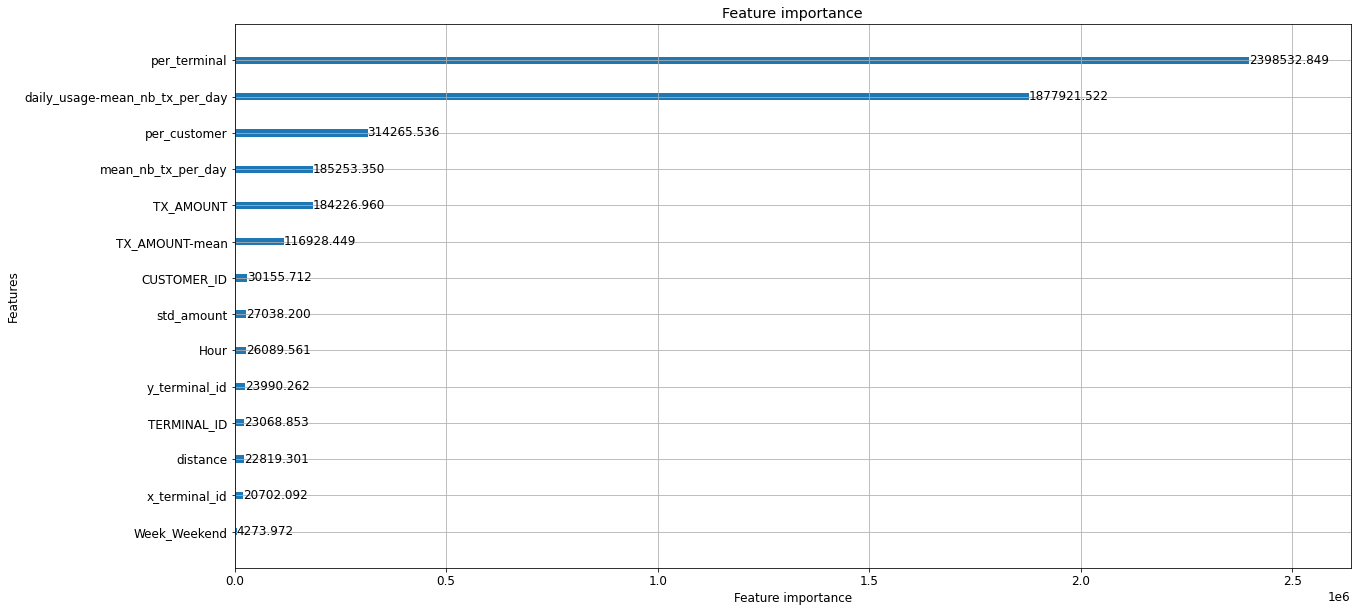

In [ ]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

0.9955452640054081


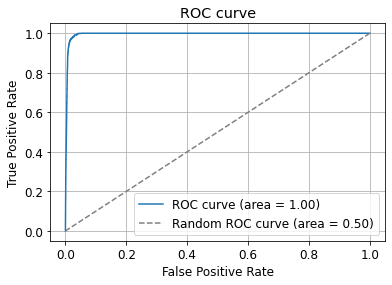

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test_true, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()


precision_score=0.5587858058999573
recall_score=0.9717472118959107
sum_score=1.530533017795868


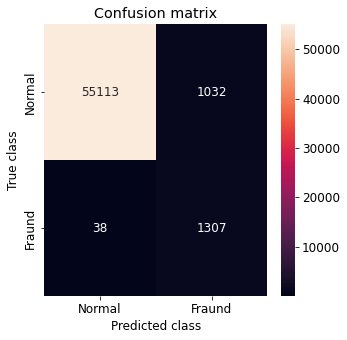

In [ ]:
# スコア(RMSE)算出
y_pred_int = np.where(y_pred > 0.85, 1, 0)
precision_score = metrics.precision_score(y_true=y_test_true, y_pred=y_pred_int)
recall_score = metrics.recall_score(y_true=y_test_true, y_pred=y_pred_int)
print(f'precision_score={precision_score}')
print(f'recall_score={recall_score}')
print(f'sum_score={recall_score+precision_score}')


import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_test_true, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraund"], yticklabels=["Normal","Fraund"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

0.7839612239197847


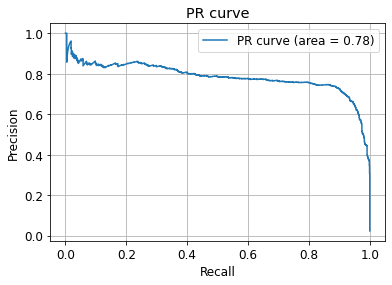

0        0
1        0
2        0
3        0
4        0
        ..
57485    0
57486    0
57487    0
57488    0
57489    0
Name: TX_FRAUD, Length: 57490, dtype: int64
              0
0      0.002538
1      0.000914
2      0.000914
3      0.000931
4      0.000914
...         ...
57485  0.000914
57486  0.001759
57487  0.001210
57488  0.000907
57489  0.000914

[57490 rows x 1 columns]


In [ ]:
# y_pred = gbm.predict(test_total)
precision, recall, thresholds = metrics.precision_recall_curve(y_test_true, y_pred)

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
print(y_test_true)
print(pd.DataFrame(y_pred))

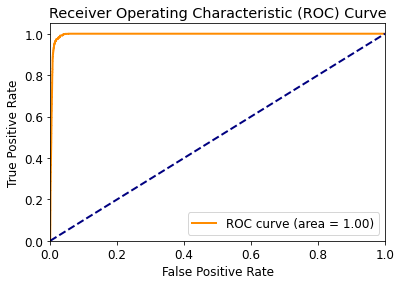

In [ ]:
# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_test_true, y_pred)
 
# AUCを計算
roc_auc = metrics.auc(fpr, tpr)
 
# ROC曲線をプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

precision_score=0.9844365642237982
recall_score=0.9541722360129845
sum_score=1.9386088002367827


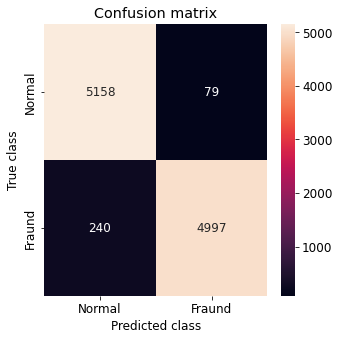

In [ ]:

# スコア(RMSE)算出
y_pred_int = np.where(y_pred_train > 0.85, 1, 0)
precision_score = metrics.precision_score(y_true=y, y_pred=y_pred_int)
recall_score = metrics.recall_score(y_true=y, y_pred=y_pred_int)
print(f'precision_score={precision_score}')
print(f'recall_score={recall_score}')
print(f'sum_score={recall_score+precision_score}')


import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=["Normal","Fraund"], yticklabels=["Normal","Fraund"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

0.996150622662844


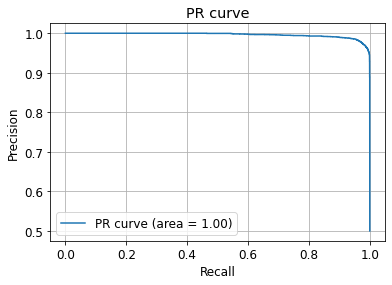

0        0
1        0
2        0
3        0
4        0
        ..
57485    0
57486    0
57487    0
57488    0
57489    0
Name: TX_FRAUD, Length: 57490, dtype: int64
              0
0      0.002538
1      0.000914
2      0.000914
3      0.000931
4      0.000914
...         ...
57485  0.000914
57486  0.001759
57487  0.001210
57488  0.000907
57489  0.000914

[57490 rows x 1 columns]


In [ ]:
# y_pred = gbm.predict(test_total)
precision, recall, thresholds = metrics.precision_recall_curve(y, y_pred_train)

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()
print(y_test_true)
print(pd.DataFrame(y_pred))